A seguir, apresento um exemplo detalhado – em Python – de como você pode resolver o problema de localização usando as bases fornecidas. Neste exemplo, usaremos dois métodos:

1. **Método Básico (referência): k‑Nearest Neighbors (kNN)**  
2. **Método Avançado: Random Forest**

O roteiro geral do script é:

1. **Importar as bibliotecas necessárias**  
2. **Ler os dados de treinamento, teste e de BTS**  
3. **Pré-processamento e definição das features**  
4. **Dividir a base de treinamento em treino/validação (usaremos 10% para avaliação dos erros)**  
5. **Treinar o modelo kNN (método básico) e o modelo Random Forest (método avançado)**  
6. **Avaliar os modelos na base de validação – calcular métricas (erro médio, mínimo, máximo e desvio-padrão) e gerar os gráficos: histograma, box-plot e scatter plot comparando as posições reais e preditas**  
7. **Usar o melhor modelo para gerar as predições na base de teste e salvar os resultados no arquivo de submissão (seguindo o layout de *submit_alunos.csv*)**

Veja abaixo um exemplo de script comentado:

---

```python
# 1. Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import math

# 2. Função para calcular a distância entre dois pontos geográficos (usando a fórmula de Haversine)
def haversine(lat1, lon1, lat2, lon2):
    """
    Calcula a distância em metros entre dois pontos definidos por latitude e longitude.
    """
    # Conversão de graus para radianos
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Diferenças
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    # Fórmula de Haversine
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    # Raio da Terra (m)
    r = 6371000
    return c * r

# 3. Leitura dos dados
# Supondo que os arquivos estejam na mesma pasta do script com os seguintes nomes:
train_df = pd.read_csv('meds_train_alunos.csv')
test_df = pd.read_csv('meds_test_alunos.csv')
bts_df = pd.read_csv('Bts.csv')  # Pode ser usado para análises adicionais se necessário

# 4. Pré-processamento e definição das features
# Seleciona as colunas de sinais (RSSI) e delays conforme especificação
features = ['rssi_1_1', 'rssi_1_2', 'rssi_1_3',
            'rssi_2_1', 'rssi_2_2', 'rssi_2_3',
            'rssi_3_1', 'rssi_3_2', 'rssi_3_3',
            'delay_1', 'delay_2', 'delay_3']

X = train_df[features]
# As variáveis alvo são latitude e longitude
y = train_df[['lat', 'lon']]

# 5. Dividir a base de treinamento em treino e validação (10% para validação)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# 6. Modelo 1 – k-Nearest Neighbors (método básico)
knn = KNeighborsRegressor(n_neighbors=5)  # Pode ajustar o número de vizinhos conforme necessário
knn.fit(X_train, y_train)
pred_knn = knn.predict(X_val)

# Calcular os erros (distância em metros) para o kNN
errors_knn = []
for i in range(len(y_val)):
    actual_lat, actual_lon = y_val.iloc[i]
    pred_lat, pred_lon = pred_knn[i]
    error = haversine(actual_lat, actual_lon, pred_lat, pred_lon)
    errors_knn.append(error)

# Métricas do kNN
print("kNN - Erro Médio:", np.mean(errors_knn))
print("kNN - Erro Mínimo:", np.min(errors_knn))
print("kNN - Erro Máximo:", np.max(errors_knn))
print("kNN - Desvio Padrão:", np.std(errors_knn))

# 7. Modelo 2 – Random Forest (método avançado)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_val)

# Calcular os erros (distância em metros) para o Random Forest
errors_rf = []
for i in range(len(y_val)):
    actual_lat, actual_lon = y_val.iloc[i]
    pred_lat, pred_lon = pred_rf[i]
    error = haversine(actual_lat, actual_lon, pred_lat, pred_lon)
    errors_rf.append(error)

# Métricas do Random Forest
print("Random Forest - Erro Médio:", np.mean(errors_rf))
print("Random Forest - Erro Mínimo:", np.min(errors_rf))
print("Random Forest - Erro Máximo:", np.max(errors_rf))
print("Random Forest - Desvio Padrão:", np.std(errors_rf))

# 8. Visualização dos resultados
# Histograma dos erros para o kNN
plt.figure()
plt.hist(errors_knn, bins=30, edgecolor='black')
plt.title("Histograma dos Erros - kNN")
plt.xlabel("Erro (metros)")
plt.ylabel("Frequência")
plt.show()

# Histograma dos erros para o Random Forest
plt.figure()
plt.hist(errors_rf, bins=30, edgecolor='black')
plt.title("Histograma dos Erros - Random Forest")
plt.xlabel("Erro (metros)")
plt.ylabel("Frequência")
plt.show()

# Box-plot dos erros
plt.figure()
plt.boxplot([errors_knn, errors_rf], labels=['kNN', 'Random Forest'])
plt.title("Box-Plot dos Erros")
plt.ylabel("Erro (metros)")
plt.show()

# Scatter plot: Posições reais vs. Posições preditas (exemplo com Random Forest)
plt.figure()
plt.scatter(y_val['lon'], y_val['lat'], color='blue', label='Real', alpha=0.6)
plt.scatter(pred_rf[:,1], pred_rf[:,0], color='red', marker='x', label='Predito RF', alpha=0.6)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Comparação: Posições Reais vs. Preditadas (Random Forest)")
plt.legend()
plt.show()

# 9. Predição na base de teste
# A base de teste possui as mesmas features (exceto lat, lon, indoor)
X_test = test_df[features]

# Utilizando o modelo com melhor desempenho (por exemplo, Random Forest)
pred_test = rf.predict(X_test)

# Criação do DataFrame de submissão conforme o template: ponto_id, lat, lon
submit_df = pd.DataFrame({
    'ponto_id': test_df['ponto_id'],
    'lat': pred_test[:, 0],
    'lon': pred_test[:, 1]
})

# Salvando o arquivo de resultados (lembre de seguir o nome conforme especificado: Resultados_EquipeX_MetodoY.csv)
submit_df.to_csv("Resultados_EquipeX_MetodoRF.csv", index=False)
print("Arquivo de submissão gerado: Resultados_EquipeX_MetodoRF.csv")
```

---

### Explicação Detalhada dos Passos:

1. **Importação e Definição da Função Haversine:**  
   - Importamos as bibliotecas essenciais para manipulação de dados, modelagem e visualizações.
   - A função `haversine` calcula a distância entre duas coordenadas (lat, lon) em metros, permitindo avaliar o erro dos modelos de localização.

2. **Leitura dos Dados:**  
   - São lidos os arquivos CSV contendo a base de treinamento (*meds_train_alunos.csv*), a base de teste (*meds_test_alunos.csv*) e os dados das BTS (*Bts.csv*). Esses dados são fundamentais para treinar e avaliar o modelo.

3. **Pré-processamento:**  
   - Selecionamos as colunas referentes aos níveis de sinal (RSSI) e aos atrasos (delay), que serão usados como variáveis de entrada (features).
   - As variáveis alvo são a latitude e longitude dos pontos de medição da base de treinamento.

4. **Divisão em Treino/Validação:**  
   - Separamos 10% dos dados de treinamento para avaliar o desempenho dos modelos (cálculo dos erros em metros).

5. **Treinamento dos Modelos:**  
   - **kNN:** É implementado como uma técnica básica de referência. Após o treinamento, as predições para a base de validação são comparadas com os valores reais.
   - **Random Forest:** Representa um método mais avançado. Também é treinado e suas predições são avaliadas.

6. **Avaliação dos Modelos:**  
   - Para cada modelo, calculamos o erro de localização (usando a fórmula de Haversine) e exibimos métricas (erro médio, mínimo, máximo e desvio-padrão).
   - São gerados gráficos (histograma, box-plot e scatter plot) para visualizar a distribuição dos erros e a comparação entre as posições reais e preditas.

7. **Predição para a Base de Teste e Geração do Arquivo de Submissão:**  
   - Utilizando o modelo com melhor desempenho (neste exemplo, optamos pelo Random Forest), realizamos as predições na base de teste.
   - Os resultados são salvos em um arquivo CSV com o formato exigido, contendo as colunas: *ponto_id, lat, lon*.

Este script serve como um guia completo – desde a leitura dos dados até a geração dos resultados – e pode ser adaptado conforme as necessidades e os ajustes dos parâmetros dos modelos. Assim, você consegue testar diferentes abordagens e analisar os erros de localização de forma detalhada.

---

Este exemplo contempla as diretrizes mínimas da especificação do projeto e pode ser estendido, por exemplo, para incluir a análise dos dados de BTS ou outras técnicas de localização e avaliação (como o uso de IA generativa para expansão da base de dados).

kNN - Erro Médio: 25.830293570111895
kNN - Erro Mínimo: 0.0
kNN - Erro Máximo: 1318.0373575682443
kNN - Desvio Padrão: 82.77642311351373
Random Forest - Erro Médio: 5.503047231514835
Random Forest - Erro Mínimo: 9.953831194844185e-10
Random Forest - Erro Máximo: 121.03527361167778
Random Forest - Desvio Padrão: 13.964801463717855


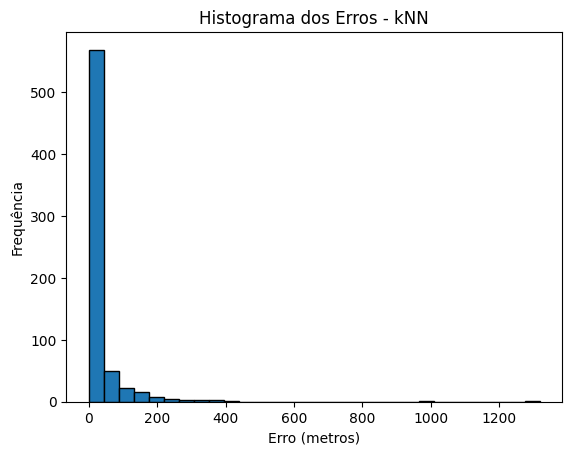

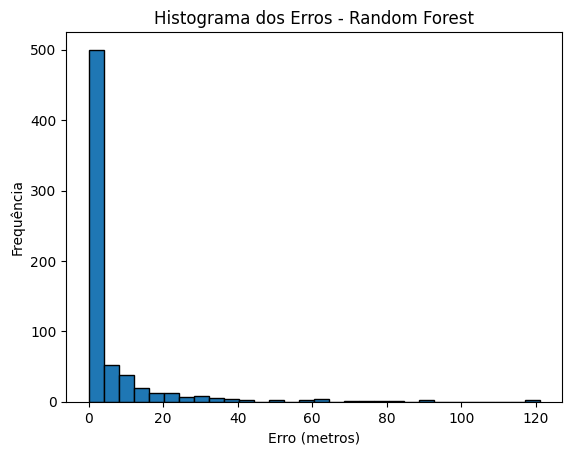

/tmp/ipykernel_10157/2513163477.py:105: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([errors_knn, errors_rf], labels=['kNN', 'Random Forest'])


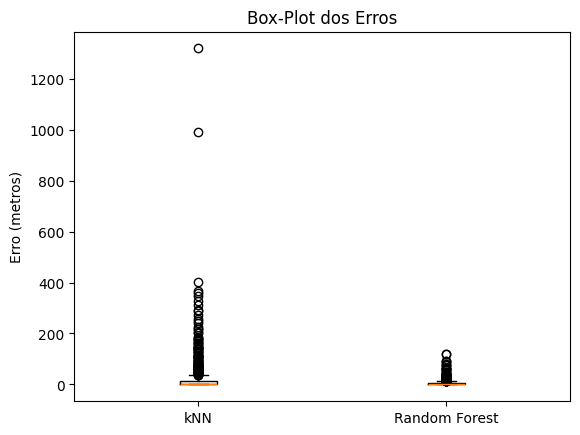

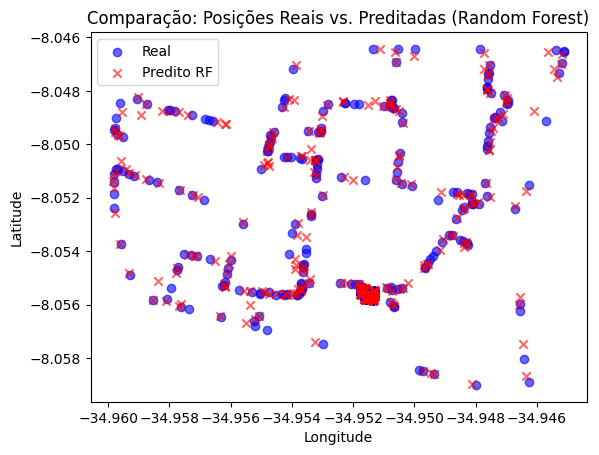

Arquivo de submissão gerado: Resultados_EquipeX_MetodoRF.csv


In [4]:
# 1. Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import math

# 2. Função para calcular a distância entre dois pontos geográficos (usando a fórmula de Haversine)
def haversine(lat1, lon1, lat2, lon2):
    """
    Calcula a distância em metros entre dois pontos definidos por latitude e longitude.
    """
    # Conversão de graus para radianos
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Diferenças
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    # Fórmula de Haversine
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    # Raio da Terra (m)
    r = 6371000
    return c * r

# 3. Leitura dos dados
# Supondo que os arquivos estejam na mesma pasta do script com os seguintes nomes:
train_df = pd.read_csv('meds_train_alunos.csv')
test_df = pd.read_csv('meds_test_alunos.csv')
bts_df = pd.read_csv('Bts.csv')  # Pode ser usado para análises adicionais se necessário

# 4. Pré-processamento e definição das features
# Seleciona as colunas de sinais (RSSI) e delays conforme especificação
features = ['rssi_1_1', 'rssi_1_2', 'rssi_1_3',
            'rssi_2_1', 'rssi_2_2', 'rssi_2_3',
            'rssi_3_1', 'rssi_3_2', 'rssi_3_3',
            'delay_1', 'delay_2', 'delay_3']

X = train_df[features]
# As variáveis alvo são latitude e longitude
y = train_df[['lat', 'lon']]

# 5. Dividir a base de treinamento em treino e validação (10% para validação)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# 6. Modelo 1 – k-Nearest Neighbors (método básico)
knn = KNeighborsRegressor(n_neighbors=5)  # Pode ajustar o número de vizinhos conforme necessário
knn.fit(X_train, y_train)
pred_knn = knn.predict(X_val)

# Calcular os erros (distância em metros) para o kNN
errors_knn = []
for i in range(len(y_val)):
    actual_lat, actual_lon = y_val.iloc[i]
    pred_lat, pred_lon = pred_knn[i]
    error = haversine(actual_lat, actual_lon, pred_lat, pred_lon)
    errors_knn.append(error)

# Métricas do kNN
print("kNN - Erro Médio:", np.mean(errors_knn))
print("kNN - Erro Mínimo:", np.min(errors_knn))
print("kNN - Erro Máximo:", np.max(errors_knn))
print("kNN - Desvio Padrão:", np.std(errors_knn))

# 7. Modelo 2 – Random Forest (método avançado)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_val)

# Calcular os erros (distância em metros) para o Random Forest
errors_rf = []
for i in range(len(y_val)):
    actual_lat, actual_lon = y_val.iloc[i]
    pred_lat, pred_lon = pred_rf[i]
    error = haversine(actual_lat, actual_lon, pred_lat, pred_lon)
    errors_rf.append(error)

# Métricas do Random Forest
print("Random Forest - Erro Médio:", np.mean(errors_rf))
print("Random Forest - Erro Mínimo:", np.min(errors_rf))
print("Random Forest - Erro Máximo:", np.max(errors_rf))
print("Random Forest - Desvio Padrão:", np.std(errors_rf))

# 8. Visualização dos resultados
# Histograma dos erros para o kNN
plt.figure()
plt.hist(errors_knn, bins=30, edgecolor='black')
plt.title("Histograma dos Erros - kNN")
plt.xlabel("Erro (metros)")
plt.ylabel("Frequência")
plt.show()

# Histograma dos erros para o Random Forest
plt.figure()
plt.hist(errors_rf, bins=30, edgecolor='black')
plt.title("Histograma dos Erros - Random Forest")
plt.xlabel("Erro (metros)")
plt.ylabel("Frequência")
plt.show()

# Box-plot dos erros
plt.figure()
plt.boxplot([errors_knn, errors_rf], labels=['kNN', 'Random Forest'])
plt.title("Box-Plot dos Erros")
plt.ylabel("Erro (metros)")
plt.show()

# Scatter plot: Posições reais vs. Posições preditas (exemplo com Random Forest)
plt.figure()
plt.scatter(y_val['lon'], y_val['lat'], color='blue', label='Real', alpha=0.6)
plt.scatter(pred_rf[:,1], pred_rf[:,0], color='red', marker='x', label='Predito RF', alpha=0.6)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Comparação: Posições Reais vs. Preditadas (Random Forest)")
plt.legend()
plt.show()

# 9. Predição na base de teste
# A base de teste possui as mesmas features (exceto lat, lon, indoor)
X_test = test_df[features]

# Utilizando o modelo com melhor desempenho (por exemplo, Random Forest)
pred_test = rf.predict(X_test)

# Criação do DataFrame de submissão conforme o template: ponto_id, lat, lon
submit_df = pd.DataFrame({
    'ponto_id': test_df['ponto_id'],
    'lat': pred_test[:, 0],
    'lon': pred_test[:, 1]
})

# Salvando o arquivo de resultados (lembre de seguir o nome conforme especificado: Resultados_EquipeX_MetodoY.csv)
submit_df.to_csv("Resultados_EquipeX_MetodoRF.csv", index=False)
print("Arquivo de submissão gerado: Resultados_EquipeX_MetodoRF.csv")